In [10]:
import numpy as np
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import seaborn
import pandas as pd

def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X.iloc[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

In [11]:
data = pd.read_excel('/home/daniel/Desktop/Projetos/mql_python/Relatório 1/dados_relatorio.xlsx')

In [12]:
ibov,itsa = data['close IBOV'].pct_change()[1:],data['close ITSA4'].pct_change()[1:]

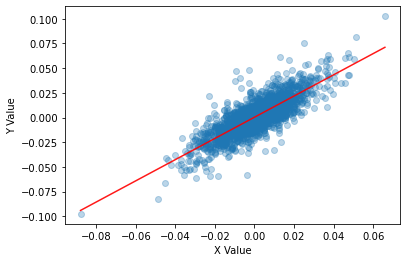

In [13]:
a = linreg(ibov,itsa)

In [14]:
a

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            close ITSA4   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3840.
Date:                Fri, 17 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:45:08   Log-Likelihood:                 6145.9
No. Observations:                1974   AIC:                        -1.229e+04
Df Residuals:                    1972   BIC:                        -1.228e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.426      0.154      -0.000       0.001
close IBOV     1.0721      0.017     61.964      0.000       1.038       1.106
==============================================================================
Omnibus:                      122.417   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              373.951
Skew:                           0.277   Prob(JB):                     6.27e-82
Kurtosis:                       5.059   Cond. No.                         71.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

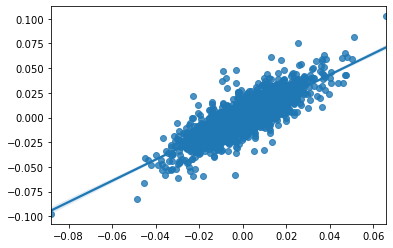

In [15]:
seaborn.regplot(ibov.values, itsa.values);


## Multiple linear regression

In [7]:
a = ['close BBAS3', 'close BBDC3', 'close BBDC4', 'close BBSE3','close BEEF3', 'close BPAC11', 'close BRAP4', 'close BRDT3']

In [16]:
def forward_aic(response, data):
    # This function will work with pandas dataframes and series
    # Initialize some variables
    explanatory = list(data.columns)
    selected = pd.Series(np.ones(data.shape[0]), name="Intercept")
    current_score, best_new_score = np.inf, np.inf
    
    # Loop while we haven't found a better model
    while current_score == best_new_score and len(explanatory) != 0:
        scores_with_elements = []
        count = 0
        # For each explanatory variable
        for element in explanatory:
            # Make a set of explanatory variables including our current best and the new one
            tmp = pd.concat([selected, data[element]], axis=1)
            # Test the set
            result = regression.linear_model.OLS(ibov, tmp).fit()
            score = result.aic
            scores_with_elements.append((score, element, count))
            count += 1
        
        # Sort the scoring list
        scores_with_elements.sort(reverse = True)
        # Get the best new variable
        best_new_score, best_element, index = scores_with_elements.pop()
        if current_score > best_new_score:
            # If it's better than the best add it to the set
            explanatory.pop(index)
            selected = pd.concat([selected, data[best_element]],axis=1)
            current_score = best_new_score
    # Return the final model
    model = regression.linear_model.OLS(ibov, selected).fit()
    return model

In [30]:
bba, bbd, its = data['close BBAS3'], data['close BBDC4'], data['close ITSA4']
ibov = data['close IBOV']
b = pd.DataFrame(np.column_stack((bba, bbd, its)), columns = ['BBAS3','BBDC4','ITSA4'])

In [31]:
results = regression.linear_model.OLS(ibov, sm.add_constant((b))).fit()

In [32]:
result = forward_aic(ibov, b)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             close IBOV   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     6978.
Date:                Fri, 17 Jul 2020   Prob (F-statistic):               0.00
Time:                        14:48:02   Log-Likelihood:                -19668.
No. Observations:                1975   AIC:                         3.934e+04
Df Residuals:                    1971   BIC:                         3.937e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.848e+04    325.851     87.389      0.000    2.78e+04    2.91e+04
BBAS3       1051.6302     58.862     17.866      0.000     936.192    1167.068
ITSA4       3140.9075    234.649     13.386      0.000    2680.722    3601.093
BBDC4       -538.2672    136.650     -3.939      0.000    -806.261    -270.274
==============================================================================
Omnibus:                      172.271   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.818
Skew:                           0.809   Prob(JB):                     5.03e-48
Kurtosis:                       2.826   Cond. No.                         100.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Beta hedging

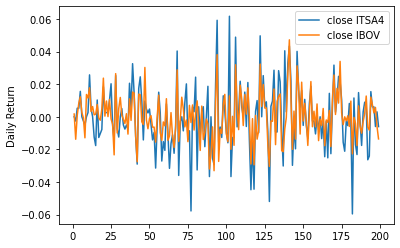

In [69]:
# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = data['close ITSA4'].pct_change()[1:200]
r_b = data['close IBOV'].pct_change()[1:200]

# Let's plot them just for fun
r_a.plot()
r_b.plot()
plt.ylabel("Daily Return")
plt.legend();

In [70]:
# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the timestamps
Y = r_a.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print(f'alpha: {alpha:.4f}')
print(f'beta :  {beta:.4f}')

alpha: -0.0006
beta :  1.0677


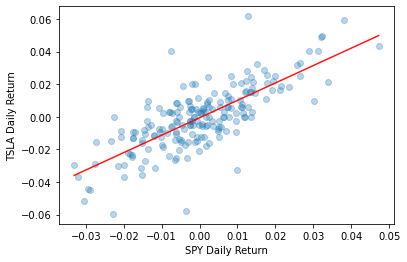

In [71]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("SPY Daily Return")
plt.ylabel("TSLA Daily Return")

 # Add the regression line, colored in red
plt.plot(X2, Y_hat, 'r', alpha=0.9);

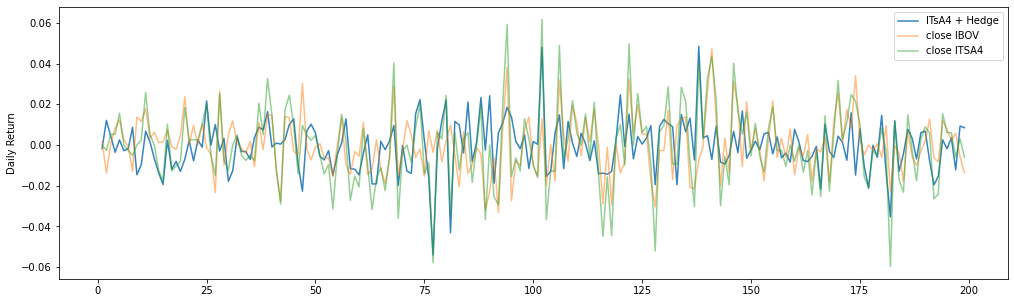

In [72]:
plt.figure(figsize=[17,5])
# Construct a portfolio with beta hedging
portfolio = -1*beta*r_b + r_a
portfolio.name = "ITsA4 + Hedge"

# Plot the returns of the portfolio as well as the asset by itself
portfolio.plot(alpha=0.9)
r_b.plot(alpha=0.5);
r_a.plot(alpha=0.5);
plt.ylabel("Daily Return")
plt.legend();

In [74]:
print(f'portfolio mean: {portfolio.mean()}, r_amean: {r_a.mean()}')
print(f'portfolio vol: {portfolio.std()}, r_a vol: {r_a.std()}')

portfolio mean: -0.0006169716652210062, r_amean: -0.0005454878769771341
portfolio vol: 0.012660865850409608, r_a vol: 0.019521679722609053


In [77]:
P = portfolio.values
alpha, beta = linreg(X,P)
print(f'alpha: {alpha}')
print(f'beta :  {beta}')

alpha: -0.000616971665221006
beta :  5.533767888366015e-16


Asset Historical Estimate:
alpha: -0.0006169716652210068
beta: 1.0676848702007673

Asset Out of Sample Estimate:
alpha: 0.00023483526412421813
beta: 0.7715428584427695
Portfolio Out of Sample:
alpha: 0.00023483526412421623
beta: -0.2961420117579972


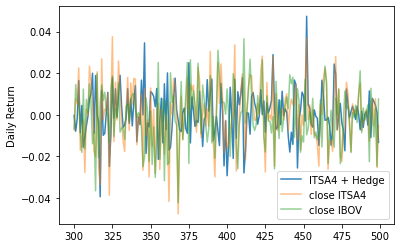

In [79]:
# Get the alpha and beta estimates over the last year

r_a = data['close ITSA4'].pct_change()[1:200]
r_b = data['close IBOV'].pct_change()[1:200]
X = r_b.values
Y = r_a.values
historical_alpha, historical_beta = linreg(X,Y)
print ('Asset Historical Estimate:')
print ('alpha: ' + str(historical_alpha))
print ('beta: ' + str(historical_beta)+'\n')

r_a = data['close ITSA4'].pct_change()[300:500]
r_b = data['close IBOV'].pct_change()[300:500]
X = r_b.values
Y = r_a.values
alpha, beta = linreg(X,Y)
print ('Asset Out of Sample Estimate:')
print ('alpha: ' + str(alpha))
print ('beta: ' + str(beta))

# Create hedged portfolio and compute alpha and beta
portfolio = -1*historical_beta*r_b + r_a
P = portfolio.values
alpha, beta = linreg(X,P)
print ('Portfolio Out of Sample:')
print ('alpha: ' + str(alpha))
print ('beta: ' + str(beta))


# Plot the returns of the portfolio as well as the asset by itself
portfolio.name = "ITSA4 + Hedge"
portfolio.plot(alpha=0.9)
r_a.plot(alpha=0.5);
r_b.plot(alpha=0.5)
plt.ylabel("Daily Return")
plt.legend();

# CAPM 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            close ITSA4   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3840.
Date:                Fri, 17 Jul 2020   Prob (F-statistic):               0.00
Time:                        16:35:56   Log-Likelihood:                 6145.9
No. Observations:                1974   AIC:                        -1.229e+04
Df Residuals:                    1972   BIC:                        -1.228e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.426      0.154      -0.000       0.001
close IBOV     1.0721      0.017     61.964      0.000       1.038       1.106
==============================================================================
Omnibus:                      122.417   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              373.951
Skew:                           0.277   Prob(JB):                     6.27e-82
Kurtosis:                       5.059   Cond. No.                         71.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

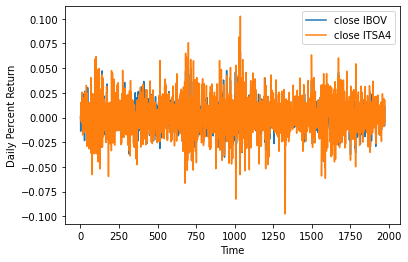

In [82]:
# choose stock
# R = get_pricing('AAPL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
R = data['close ITSA4'].pct_change()[1:]
# risk-free proxy
# R_F = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
#R_F = data['close IBOV'].pct_change()[1:] #dados do tesouro direto, por exemplo

# find it's beta against market
# M = get_pricing('SPY', start_date=start_date, end_date=end_date, fields='price').pct_change()[1:]
M = data['close IBOV'].pct_change()[1:]

AAPL_results = regression.linear_model.OLS(R, sm.add_constant(M)).fit() # R - R_F
AAPL_beta = AAPL_results.params[1]

M.plot()
R.plot()
# R_F.plot()
plt.xlabel('Time')
plt.ylabel('Daily Percent Return')
plt.legend();

AAPL_results.summary()